# Scientific Computing - Practice sessions  : Audio command recognition by DTW and classification

**Group name:**

**Names :**

**Surnames :**

The Practice sessions will permit testing the dynamic programming algorithm (DTW) seen in Exercise session (TD) and then implement an audio recognition system for isolated words (constituting orders for drones).


These sessions are divided into 3 parts: 
- Part I: DTW and application of the TD
- Part II: Audio control word recognition system
- Part III: Comparison of dynamic programming with a classification method after data pre-processing by PCA

For **parts II and III**, you will test the audio recognition system on two sets of voices that will serve as a learning base (references) and a test base (sounds to be recognized) respectively. The list of the 13 drone commands are: *Landing, Takeoff, Takeoff, Advance, Right turn, Backward, Left turn, Right, Flip, Left, Stop, Higher, Lower and State of Emergency.*

To do this, you must per group of 2 students (number of students **MANDATORY**):
1. **Propose a study** that you will detail on a report.
For example, *influence male voices VS female voices, compare your own voices to the database, test the impact of different background noises on recognition...*];
2. Create, according to the objective of your study, your own learning base and test base from the proposed corpus and the voices and sounds you have recorded   [*audio parameters: 16 KHz, mono, 16 bits, *.wav format**];
3. Test the DTW and a classification method with pre-processing by PCA;
4. Evaluate the results; 
5. Write a pdf report presenting the study, the results by the 2 methods and your comments and conclusions on your study (Max. length: 8 pages).



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import array, zeros, full, argmin, inf, ndim
import scipy
import sklearn
import math
import IPython.display as ipd
from scipy.spatial import distance
import numpy as np
import os
from sklearn.model_selection import train_test_split
import noisereduce as nr
import librosa
import librosa.display

/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Part I: Implementation of the dynamic programming algorithm 

1. Write a function in DTW python that implements the calculation and display of the cost matrix defined in TD. 

2. In order to easily adapt the cost calculation according to the nature of the data (and therefore the distances used), write a function for each distance (Euclidean, letters, sounds) that will appear as a parameter of the DTW function.

In [2]:
def dtw(s1,s2,dist=distance.euclidean,l_const=np.array([1,1,1]),g_const = None,plot=False):
    """
    :ts1: float - timeseries1
    :ts2: float - timeseries2
    :dist: lamda - distance
    """

    s1 = np.insert(s1, 0, 0,axis=0)
    s2 = np.insert(s2, 0, 0,axis=0)
    m = len(s1)
    n = len(s2)
    
    
    DTW = np.full((n,m),float("inf"),dtype=float)
    
    DTW[0,0] = 0
    
    for i in range(1,n):
        if g_const != None: 
            newms = max(1,i-g_const)
            newme = min(m,i+g_const)
        else: 
            newms = 1;
            newme = m;
            
        for j in range(newms,newme):
            cost = dist(s1[j],s2[i])
            DTW[i,j] = np.min(np.array([DTW[i-1,j],DTW[i-1,j-1], DTW[i,j-1]])
                              + cost*l_const)

    path = list()
    path.append([n-1,m-1,DTW[n-1,m-1]])
    i = n-1
    j = m-1
    while (True):
        k = np.argmin([DTW[i-1,j],DTW[i-1,j-1],DTW[i,j-1]])
        if k==0:
            path.append([i-1,j,DTW[i-1,j]])
            i = i-1
        elif k==1:
            path.append([i-1,j-1,DTW[i-1,j-1]])
            j = j-1
            i = i-1
        else:
            path.append([i,j-1,DTW[i,j-1]])
            j = j-1
        if i==0 and j==0:
            break
    path = np.array(path)
    if plot:
        print(DTW[n-1,m-1]/(n+m - 2))
        plt.imshow(DTW, origin='lower', interpolation='nearest')
        plt.plot(path[:,1], path[:,0], 'w')
        plt.show()

    return DTW[n-1,m-1]/(n+m - 2)#, path, DTW

3.6


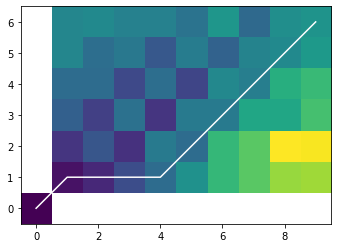

3.6

In [3]:
x = np.array([-2,10,-10,15,-13,20,-5,14,2])
y = np.array([3,-13,14,-7,9,-2])
euclidean_norm = lambda x, y: np.abs(x - y)
dtw(x.T,y.T,dist=euclidean_norm,g_const=None,plot=True)

0.16666666666666666


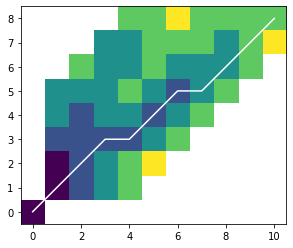

0.16666666666666666

In [4]:
x = np.array(['A','T','G','G','T','A','C','G','T','C'])
y = np.array(['A','A','G','T','A','G','G','C'])
symbols_norm = lambda x, y: 0 if x == y else 1
dtw(x.T,y.T,dist=symbols_norm,g_const=4,plot=True)

0.16666666666666666


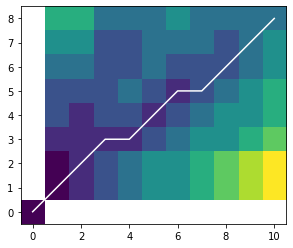

0.16666666666666666

In [5]:
x = np.array(['A','T','G','G','T','A','C','G','T','C'])
y = np.array(['A','A','G','T','A','G','G','C'])
symbols_norm = lambda x, y: 0 if x == y else 1
dtw(x,y,dist=symbols_norm,plot=True)

0.16666666666666666


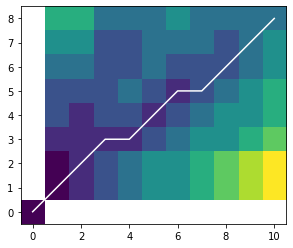

0.16666666666666666

In [6]:
x = np.array(['A','T','G','G','T','A','C','G','T','C'])
y = np.array(['A','A','G','T','A','G','G','C'])
symbols_norm = lambda x, y: 0 if x == y else 1
dtw(x.T,y.T,dist=symbols_norm,plot=True)

#### Application to exercises 

1. Test your programs on the exercises seen in TD. 

2. Modify the local constraints, i.e. the weights according to the directions. 

3. Add the consideration of global constraints, i. e. non-calculation when the boxes are too far from the diagonal (see exercise TD DNA sequence). From which position do global constraints not change the results?

# Part II: Audio control word recognition system

On the shared space, you will find audio recordings of command words for a quadricopter drone composed of several male french speakers (noted M01...M13) and female french speakers (F01...F05).

You can thus divide all the data into learning bases that will serve as references and test bases to evaluate recognition by dynamic programming.

The following lines of code allow you to transform the audio file into a matrix of parameters called MFCC (Mel Frequency Cepstral Coefficient) using the *librosa* python library. These settings are used to extract the best possible frequency voice content from the audio signal.

The output matrix is composed of as many column vectors as analysis frames. The number of lines corresponds to the size of the representative vector: here 12.


**Audio file upload:**

In [7]:
y, sr = librosa.load("M12_etatdurgence.wav",sr=16000,dtype=np.float16, res_type='kaiser_fast')
y1 = nr.reduce_noise(audio_clip=y, noise_clip=y, verbose=False)
yt, index = librosa.effects.trim(y,top_db=20)

In [8]:
ipd.Audio(yt,rate=sr)

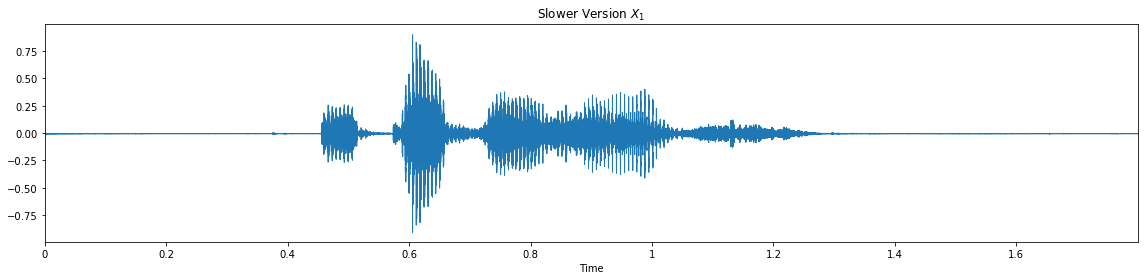

In [9]:
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sr)
plt.title('Slower Version $X_1$')
plt.tight_layout()

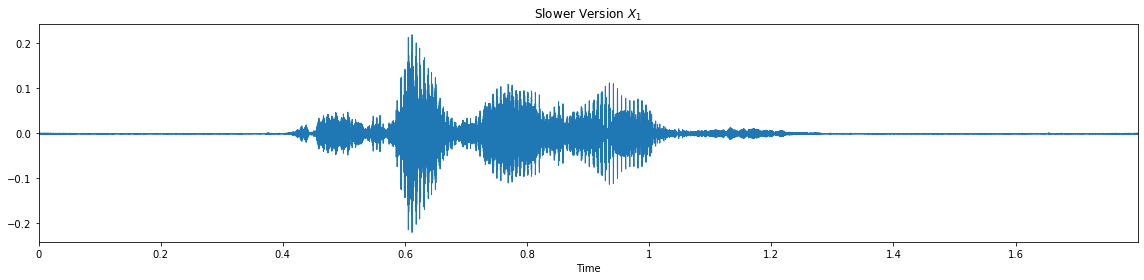

In [10]:
import librosa.display
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y1, sr=sr)
plt.title('Slower Version $X_1$')
plt.tight_layout()

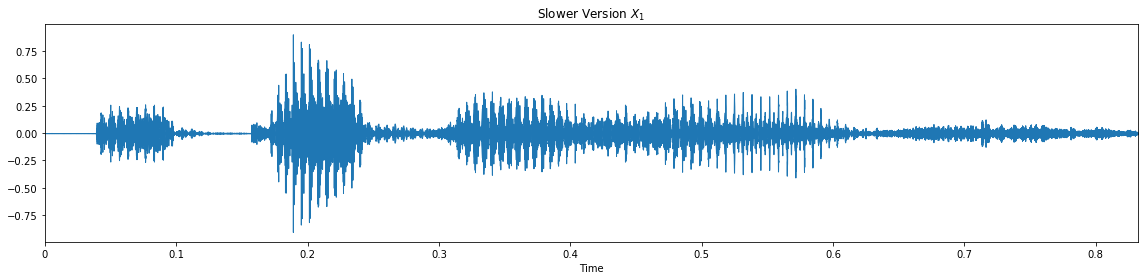

In [11]:
import librosa.display
plt.figure(figsize=(16, 4))
librosa.display.waveplot(yt, sr=sr)
plt.title('Slower Version $X_1$')
plt.tight_layout()

**MFCC extraction**

In [12]:
mfcc = librosa.feature.mfcc(y=yt, sr=sr, hop_length=1024, htk=True, n_mfcc=12)

In [13]:
scaler = sklearn.preprocessing.StandardScaler()
mfcc_procss = scaler.fit_transform(mfcc)

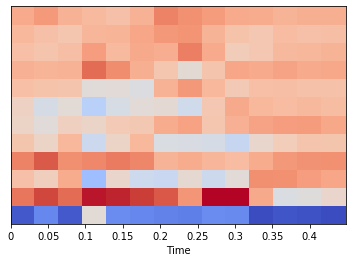

In [14]:
%matplotlib inline
librosa.display.specshow(mfcc_procss, sr=sr, x_axis='time')

In [15]:
mfcc_procss.shape

(12, 14)

In [128]:
def wav2mfcc(file_path, max_len=15, n_mfcc = 13, pad = False, delta = False, delta_delta = False):
    wave, sr = librosa.load(file_path, sr=16000,dtype=np.float16, res_type='kaiser_fast')
    yrn = nr.reduce_noise(audio_clip=wave, noise_clip=wave, verbose=False)
    yf, index = librosa.effects.trim(yrn,top_db=20)

    mfcc = librosa.feature.mfcc(y=yf, sr=16000, hop_length=1024, htk=True, n_mfcc=n_mfcc)
    if delta:
        mfcc_delta = librosa.feature.delta(mfcc,mode='nearest')
    if delta_delta:
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2,mode='nearest')
    
    if not pad:
        return yf,mfcc
    
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        if delta:
            mfcc_delta = np.pad(mfcc_delta, pad_width=((0, 0), (0, pad_width)), mode='constant')
        if delta_delta:
            mfcc_delta2 = np.pad(mfcc_delta2, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
        if delta:
            mfcc_delta = mfcc_delta[:, :max_len]
        if delta_delta:
            mfcc_delta2 = mfcc_delta2[:, :max_len]
    if delta and delta_delta:
        return yf,np.concatenate((mfcc, mfcc_delta,mfcc_delta2))
    elif delta and not delta_delta:
        return yf,np.concatenate((mfcc, mfcc_delta))
    else:
        return yf,mfcc

In [17]:
mfcc = wav2mfcc("M11_etatdurgence.wav",delta=True)

In [18]:
mfcc.shape

(13, 14)

In [19]:
mfcc1 = wav2mfcc("M12_droite.wav",delta=True)

In [20]:
mfcc1.shape

(13, 5)

In [21]:
mfcc2 = wav2mfcc("M12_etatdurgence.wav",delta=True)

In [22]:
mfcc2.shape

(13, 11)

104.94922959150125


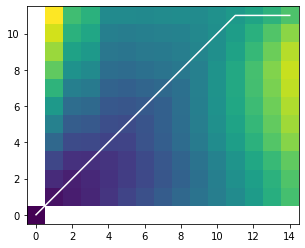

In [23]:
dtw(mfcc.T, mfcc2.T,dist=distance.euclidean,plot=True);

156.750954808194


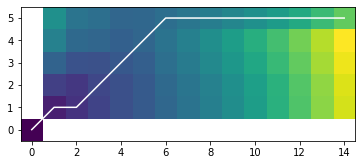

In [24]:
dtw(mfcc.T, mfcc1.T, dist=distance.euclidean,plot=True);

**Application of DTW**

1. Carry out a study that you will detail on a report (for example, *influence male voices VS female voices, compare your own voice with the database, test the impact of different background noises on recognition...*) and create your own learning database and test database from the corpus and the voices and noises you have recorded. 

2. Apply DTW to your corpora.

**Settings for audio recordings of your personal voices:**

16 KHz, mono, 16 bits, *.wav* format


In [39]:
model = sklearn.decomposition.PCA(n_components=3, whiten=True)

In [44]:
model = sklearn.decomposition.PCA(n_components=3, whiten=True)
model.fit(mfcc.T)
Y = model.transform(mfcc.T)

In [43]:
Y.shape

(14, 3)

NameError: name 'Y' is not defined

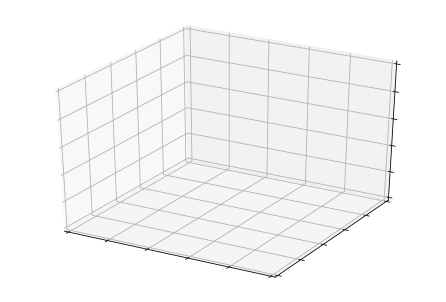

In [269]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

ax.scatter(Y[:,0],Y[:,1], Y[:,2], c='r', marker='o')

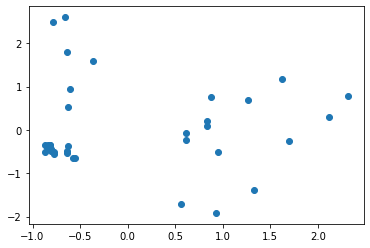

In [243]:
model.fit(mfcc1_procss.T)
Y = model.transform(mfcc1_procss.T)
plt.scatter(Y[:,0], Y[:,1])

In [222]:
model.fit(mfcc2_procss.T)
Y = model.transform(mfcc2_procss.T)
plt.scatter(Y[:,0], Y[:,1])

NameError: name 'mfcc2_procss' is not defined

**Assessment of recognition**

1. Calculate the system confusion matrix (in line with the references and in column the system outputs). 
You can use the *confusion_matrix* function of the *sklearn* library.


2. Calculate the recognition score: number of well recognized files on number of tested files. 

*Verification:*
- if you use the M01 reference and test file, you must get no errors.
- if you use as M01 reference file and M02 test file, you must get two errors.

## Part III: Comparison of dynamic programming with a classification method after data pre-processing

In this section, we will compare the results of DTW with those of a data classification method: the k-nearest neighbors (k-nn).

We will use the functions to calculate the PCA and k-nn via the python library *scikit-learn*.


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
import os
import glob2
import progressbar
from shutil import copyfile
from sklearn import metrics
from sklearn.model_selection import train_test_split
import scikitplot as skplt

labels = ["tournegauche","tournedroite","recule","plushaut",
          "plusbas","gauche","faisunflip","etatdurgence","droite",
          "decollage","avance","atterrissage","arretetoi"]

In [109]:
for label in labels:
    os.mkdir("data/"+label)
    
def moveData(path,dst_path,labels,char=''):
    files = os.listdir(path)
    for label in labels:
        for file in files:
            if np.char.find(file,label) == 4:
                copyfile(path+file, dst_path+label+'/'+char+file)

moveData("corpus/drone_withoutnoise/","data/",labels)
moveData("corpus/drone_noise/","data/",labels,'N')

FileExistsError: [Errno 17] File exists: 'data/tournegauche'

In [60]:

def collect_data_v3(dataset_name):
    X = []
    y = []
    files = glob2.glob(f'{dataset_name}/**/*.WAV')
    np.random.shuffle(files)
    for path in files:
        sample_class = path.split('/')[1]
        
        mfcc = wav2mfcc(path,max_len=15,n_mfcc = 13,pad=True,delta=True,delta_delta=True)
        X.append(mfcc)
        y.append(labels.index(sample_class))
    return np.array(X),y

In [61]:
X,y = collect_data_v3('data')

In [97]:
nsamples, nx, ny = X.shape
X_f = X.reshape((nsamples,nx*ny))

X_train,X_test,y_train,y_test = train_test_split(X_f, y, test_size=0.3)

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

pca = sklearn.decomposition.PCA(n_components=3).fit(X_train)
X_train_reduce = pca.transform(X_train)


In [98]:
X_train_reduce.shape

(200, 3)

#### PCA preprocessing

To test a classification method, the size of the MFCCs must first be reduced:

1. From all the records in the learning database, perform a Principal Component Analysis (PCA) using the *PCA* function of the *scikit-learn* library and then project the test data into this new database. 

*Note:* You can also implement the PCA by
extracting the 3 eigenvectors, noted $X_1$, $X_2$, $X_3$, associated with the 3 largest eigenvalues of the
variance-covariance $\Sigma_{App}$ (by the functions *np.cov* and *np.linalg.eig*). These eigenvectors will constitute the new benchmark P. Then project the data from the learning and test database into this new database by multiplying each vector by the database $P =[X_1X_2X_3]$.


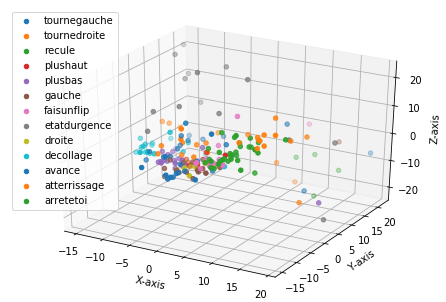

In [99]:
fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
colors = plt.cm.get_cmap('hsv', 13)
for i in range(0,13):
    X_label = X_train_reduce[np.array(y_train)==i]
    ax.scatter(X_label[:,0],X_label[:,1], X_label[:,2]#, c=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
               ,label=labels[i], marker='o')
ax.legend(loc='best')


#### Classification by k nearest neighbors

In artificial intelligence, the k nearest neighbor method (*k-nn*) is a supervised method. In this context, there is a learning database of "label-data" pairs. To estimate the output associated with a new input $x$, the $k$ nearest neighbor  method consists of taking into account (in the same way) the $k$ learning samples whose input is closest to the new input $x$, according to a distance to be defined. The associated algorithm and an example are given below.

<img src="files/knn.jpg" width="700" height="500" >

<img src="files/kppv.png" width="300" height="300" >

**Example of classification by k-nn.** The test sample (green circle) must be classified either in the first
class of blue squares, or in the second class of red triangles. 
If k = 3 (full circle), it is assigned to the second class because there are 2 triangles and only 1 square inside the inner circle. 
If k = 5 (dotted circle), it is assigned to the first class (3 squares against 2 triangles inside the outer circle)


1. Using the *KNeighborsClassifier* function of the *sklearn.neighbors library*, perform a classification by k-nn on the learning and test basis you have predefined (take $k=1$).

2. Evaluate the k-nn method by calculating the confusion matrix and the recognition rate.

3. Change the value of $k$ for k-nn. Do you improve recognition scores?

4. Compare your results with those of DTW.

In [100]:
grid_params = {
    'n_neighbors': np.arange(2, 25),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
for n in range(2,200,5):
    pca = sklearn.decomposition.PCA(n_components=n).fit(X_train)
    X_train_reduce = pca.transform(X_train)
    X_test_reduce = pca.transform(X_test)
    
    clf = KNeighborsClassifier()
    knn_gscv = GridSearchCV(clf, grid_params, cv=6)
    knn_gscv.fit(X_train_reduce, y_train)
    print("n=",n,knn_gscv.best_params_, knn_gscv.best_score_, knn_gscv.score(X_test_reduce,y_test))

/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 2 {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'} 0.47 0.36046511627906974


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 7 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.795 0.7790697674418605


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 12 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.825 0.8953488372093024


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 17 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.84 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 22 {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'} 0.87 0.8255813953488372


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 27 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.865 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 32 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.875 0.9069767441860465


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 37 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.88 0.9069767441860465


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 42 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.875 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 47 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8953488372093024


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 52 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.86 0.8953488372093024


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 57 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.865 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 62 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.865 0.8604651162790697


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 67 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.875 0.8604651162790697


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 72 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.875 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 77 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 82 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 87 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 92 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 97 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.865 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 102 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.865 0.8953488372093024


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 107 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.865 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 112 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.865 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 117 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 122 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 127 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 132 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.872093023255814


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 137 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 142 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 147 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8953488372093024


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 152 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 157 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8953488372093024


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 162 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 167 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 172 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 177 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 182 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 187 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 192 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582
n= 197 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.87 0.8837209302325582


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [101]:
pca = sklearn.decomposition.PCA(n_components=37).fit(X_train)
X_train_reduce = pca.transform(X_train)
X_test_reduce = pca.transform(X_test)

clf = KNeighborsClassifier()
knn_gscv = GridSearchCV(clf, grid_params, cv=6)



knn_gscv.fit(X_train_reduce, y_train)

/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=6, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [102]:
print("n=",n,knn_gscv.best_params_, knn_gscv.best_score_)

n= 197 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.88


In [103]:
knn_gscv.score(X_test_reduce,y_test)

0.9069767441860465

In [104]:
y_pred = knn_gscv.predict(X_test_reduce)

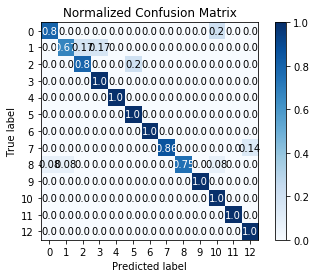

In [106]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

In [107]:
print(sklearn.metrics.classification_report(y_test, y_pred,digits=2))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.67      0.73         6
           2       0.80      0.80      0.80         5
           3       0.91      1.00      0.95        10
           4       1.00      1.00      1.00         3
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         9
           7       1.00      0.86      0.92         7
           8       1.00      0.75      0.86        12
           9       1.00      1.00      1.00         4
          10       0.82      1.00      0.90         9
          11       1.00      1.00      1.00         9
          12       0.67      1.00      0.80         2

    accuracy                           0.91        86
   macro avg       0.89      0.91      0.90        86
weighted avg       0.92      0.91      0.91        86



In [132]:
yr, mfcc_thang = wav2mfcc('thang/plusbas.wav',max_len=15,n_mfcc = 13,pad=True,delta=True,delta_delta=True)

In [134]:
ipd.Audio(yr,rate=sr)

In [135]:
mfcc_thang.shape

(39, 15)

In [136]:
nx, ny = mfcc_thang.shape
mfcc_thang = mfcc_thang.reshape((1,nx*ny))

In [137]:
mfcc_thang = scaler.transform(mfcc_thang)
mfcc_thang = pca.transform(mfcc_thang)

In [138]:
y_pred = knn_gscv.predict(mfcc_thang)

In [139]:
labels[y_pred[0]]

'plusbas'

In [11]:
import os
import glob2
import progressbar
from shutil import copyfile
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib notebook
import scikitplot as skplt

In [90]:
labels = ["tournegauche","tournedroite","recule","plushaut",
          "plusbas","gauche","faisunflip","etatdurgence","droite",
          "decollage","avance","atterrissage","arretetoi"]
for label in labels:
    os.mkdir("data/"+label)

In [95]:
def moveData(path,dst_path,labels):
    files = os.listdir(path)
    for label in labels:
        for file in files:
            if np.char.find(file,label) == 4:
                copyfile(path+file, dst_path+label+'/N'+file)


In [96]:
moveData("corpus/drone_noise/","data/",labels)

In [119]:
number_of_classes = 0
class_to_number = {}

def collect_data(dataset_name):
    global class_to_number
    global number_of_classes
    X = []
    y = []
    for path in glob2.glob(f'{dataset_name}/**/*.WAV'):
        sample_class = path.split('/')[1]
        mfcc = None
        if sample_class[0]=='N':
            pass
        else:
            _,_,mfcc = readAudio2mfcc(path,top_db=15)
            X.append(np.array(mfcc).T)
            if sample_class not in class_to_number:
                class_to_number[sample_class] = number_of_classes
                number_of_classes += 1
            class_number = class_to_number[sample_class]
            y.append(class_number)
    return train_test_split(X, y, test_size=0.25)

In [120]:
X_train, X_test, y_train, y_test = collect_data('data')

In [121]:
X_train[2].shape

(8, 13)

In [122]:
y_true = []
y_pred = []
bar = progressbar.ProgressBar(maxval=len(y_test))
for sample, sample_class in bar(zip(X_test, y_test)):
    min_dist = np.inf
    predicted_class = None
    for other, other_class in zip(X_train, y_train):
        distance= dtw(sample, other)
        if distance < min_dist:
            min_dist = distance
            predicted_class = other_class
    y_true.append(sample_class)
    y_pred.append(predicted_class)

100% |########################################################################|


<IPython.core.display.Javascript object>


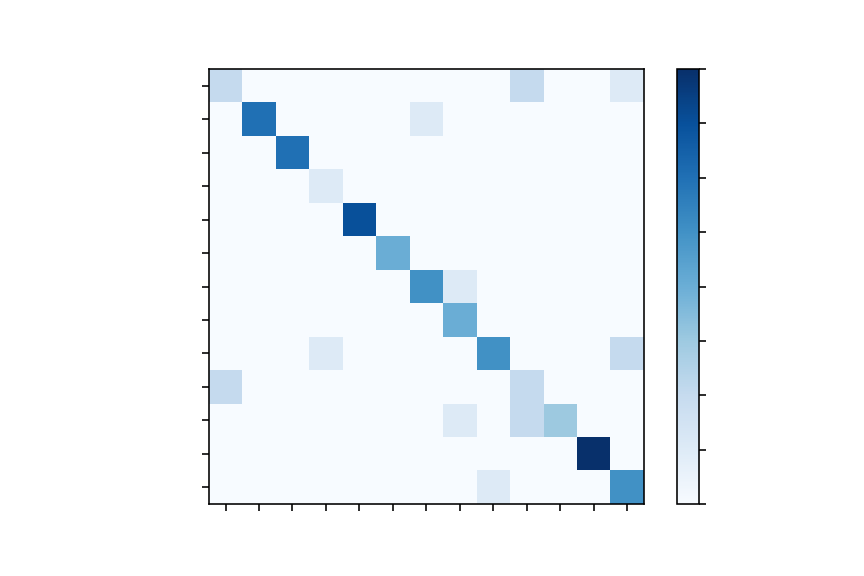

In [123]:
%matplotlib notebook
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_true, y_pred, normalize=False)
plt.show()

In [124]:
print(sklearn.metrics.classification_report(y_true, y_pred,digits=2))

              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       1.00      0.86      0.92         7
           2       1.00      1.00      1.00         6
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         4
           6       0.83      0.83      0.83         6
           7       0.67      1.00      0.80         4
           8       0.83      0.62      0.71         8
           9       0.33      0.50      0.40         4
          10       1.00      0.50      0.67         6
          11       1.00      1.00      1.00         8
          12       0.62      0.83      0.71         6

    accuracy                           0.81        72
   macro avg       0.79      0.81      0.78        72
weighted avg       0.84      0.81      0.81        72



# version 2

In [99]:
number_of_classes = 0
class_to_number = {}

def collect_data_v2(dataset_name):
    global class_to_number
    global number_of_classes
    X = []
    y = []
    
    files = glob2.glob(f'{dataset_name}/**/*.WAV')
    np.random.shuffle(files)
    print(len(files))
    for path in files:
        sample_class = path.split('/')[1]
        
        mfcc = wav2mfcc(path,max_len=15,n_mfcc = 13)
        X.append(mfcc)
        if sample_class not in class_to_number:
            class_to_number[sample_class] = number_of_classes
            number_of_classes += 1
        class_number = class_to_number[sample_class]
        y.append(class_number)
    return train_test_split(np.array(X), y, test_size=0.2)

In [100]:
X_train, X_test, y_train, y_test = collect_data_v2('data')

286


In [101]:
X_train.shape

(228, 39, 15)

In [102]:
X_test.shape

(58, 39, 15)

In [103]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [104]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

In [105]:
X_train_std.mean()

2.130882398440846e-18

In [106]:
max_score = 0
max_n = 0
for n in range(20,200,5):
    pca = sklearn.decomposition.PCA(n_components=n).fit(X_train)
    X_reduce = pca.transform(X_train_std)
    X_test_reduce = pca.transform(X_test_std)
    print("n=",n)
    
    for i in range(2,4):
        clf = KNeighborsClassifier(n_jobs=-1,n_neighbors=i,weights='uniform')
        clf.fit(X_reduce, y_train)
        k = clf.score(X_test_reduce, y_test)
        if (k > max_score):
            max_score = k
            max_n = n;
        print("--k=",i,k)
print(max_n, max_score)

n= 20
--k= 2 0.8448275862068966
--k= 3 0.8620689655172413
n= 25
--k= 2 0.8620689655172413
--k= 3 0.8448275862068966
n= 30
--k= 2 0.896551724137931
--k= 3 0.8620689655172413
n= 35
--k= 2 0.8620689655172413
--k= 3 0.8620689655172413
n= 40
--k= 2 0.8620689655172413
--k= 3 0.8793103448275862
n= 45
--k= 2 0.8448275862068966
--k= 3 0.8620689655172413
n= 50
--k= 2 0.8620689655172413
--k= 3 0.8793103448275862
n= 55
--k= 2 0.8275862068965517
--k= 3 0.8793103448275862
n= 60
--k= 2 0.8275862068965517
--k= 3 0.8793103448275862
n= 65
--k= 2 0.7758620689655172
--k= 3 0.8620689655172413
n= 70
--k= 2 0.7931034482758621
--k= 3 0.8620689655172413
n= 75
--k= 2 0.8275862068965517
--k= 3 0.8793103448275862
n= 80
--k= 2 0.8275862068965517
--k= 3 0.8793103448275862
n= 85
--k= 2 0.8275862068965517
--k= 3 0.8793103448275862
n= 90
--k= 2 0.8103448275862069
--k= 3 0.8793103448275862
n= 95
--k= 2 0.8448275862068966
--k= 3 0.8793103448275862
n= 100
--k= 2 0.8448275862068966
--k= 3 0.8620689655172413
n= 105
--k= 2 

max_len = 15, n_mfcc = 13 => acc = 75%

In [517]:
y_train = np.array(y_train)

In [518]:
[ np.sum(y_train == i) for i in range(13)]

[19, 17, 17, 19, 35, 36, 19, 19, 15, 19, 17, 18, 14]

In [ ]:
plt.bar(X_test, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')

## version 3

In [107]:
number_of_classes = 0
class_to_number = {}

def collect_data_v3(dataset_name):
    global class_to_number
    global number_of_classes
    X = []
    y = []
    
    files = glob2.glob(f'{dataset_name}/**/*.WAV')
    np.random.shuffle(files)
    #print(len(files))
    for path in files:
        sample_class = path.split('/')[1]
        
        mfcc = wav2mfcc(path,max_len=15,n_mfcc = 13)
        X.append(mfcc)
        if sample_class not in class_to_number:
            class_to_number[sample_class] = number_of_classes
            number_of_classes += 1
        class_number = class_to_number[sample_class]
        y.append(class_number)
    return X,y

In [108]:
X,y = collect_data_v3('data')

In [109]:
X = np.array(X)
nsamples, nx, ny = X.shape
X_f = X.reshape((nsamples,nx*ny))

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_f)
X_n = scaler.transform(X_f)
X_n  = scaler.transform(X_f)

In [111]:
grid_params = {
    'n_neighbors': np.arange(2, 25),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
for n in range(2,200,5):
    pca = sklearn.decomposition.PCA(n_components=n).fit(X_n)
    X_reduce = pca.transform(X_n)
    
    clf = KNeighborsClassifier()
    knn_gscv = GridSearchCV(clf, grid_params, cv=6)
    knn_gscv.fit(X_reduce, y)
    print("n=",n,knn_gscv.best_params_, knn_gscv.best_score_)

/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 2 {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'uniform'} 0.47202797202797203


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 7 {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'} 0.8181818181818182


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 12 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.8636363636363636


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 17 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.8741258741258742


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 22 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.8811188811188811


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 27 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.8986013986013986


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 32 {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 37 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 42 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.8951048951048951


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 47 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 52 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.8986013986013986


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 57 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.8951048951048951


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 62 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.8986013986013986


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 67 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.8986013986013986


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 72 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 77 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 82 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9090909090909091


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 87 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 92 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 97 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 102 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 107 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 112 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 117 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 122 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 127 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 132 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 137 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 142 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 147 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 152 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 157 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 162 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 167 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 172 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 177 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 182 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 187 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


n= 192 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9055944055944056
n= 197 {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'} 0.9020979020979021


/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## version 3

In [285]:
number_of_classes = 0
class_to_number = {}

def collect_data_v2(dataset_name):
    global class_to_number
    global number_of_classes
    X = []
    y = []
    
    files = glob2.glob(f'{dataset_name}/**/*.WAV')
    np.random.shuffle(files)
    for path in files:
        sample_class = path.split('/')[1]
        mfcc = None
        if sample_class[0]=='N':
            pass
        else:
            mfcc = wav2mfcc(path,max_len=15)
            X.append(mfcc)
            if sample_class not in class_to_number:
                class_to_number[sample_class] = number_of_classes
                number_of_classes += 1
            class_number = class_to_number[sample_class]
            y.append(class_number)
    return train_test_split(np.array(X), y, test_size=0.2)

In [286]:
X_train, X_test, y_train, y_test = collect_data_v2('data')

In [289]:
X_train.shape

(264, 20, 15)

In [291]:
for n in range(2,15):
    X_train_PCA = []
    X_test_PCA = []
    for x in X_train:
        model = sklearn.decomposition.PCA(n_components=n, whiten=True)
        model.fit(x.T)
        X_train_PCA.append(model.transform(x.T))
    for x in X_test:
        model = sklearn.decomposition.PCA(n_components=n, whiten=True)
        model.fit(x.T)
        X_test_PCA.append(model.transform(x.T))
    X_train_PCA=np.array(X_train_PCA)
    X_test_PCA=np.array(X_test_PCA)
    
    nsamples, nx, ny = X_train_PCA.shape
    X_train_PCA = X_train_PCA.reshape((nsamples,nx*ny))

    nsamples, nx, ny = X_test_PCA.shape
    X_test_PCA = X_test_PCA.reshape((nsamples,nx*ny))
    
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(X_train_PCA)
    X_train_std = scaler.transform(X_train_PCA)
    X_test_std  = scaler.transform(X_test_PCA)
    
    print("n=",n)
    for i in range(2,12):
        clf = KNeighborsClassifier(n_jobs=-1,n_neighbors=i,weights='uniform')
        clf.fit(X_reduce, y_train)
        print("--k=",i,clf.score(X_test_reduce, y_test))

n= 2
--k= 2 0.10606060606060606
--k= 3 0.12121212121212122
--k= 4 0.13636363636363635
--k= 5 0.12121212121212122
--k= 6 0.09090909090909091
--k= 7 0.12121212121212122
--k= 8 0.16666666666666666
--k= 9 0.15151515151515152
--k= 10 0.13636363636363635
--k= 11 0.12121212121212122
n= 3
--k= 2 0.10606060606060606
--k= 3 0.12121212121212122
--k= 4 0.13636363636363635
--k= 5 0.12121212121212122
--k= 6 0.09090909090909091
--k= 7 0.12121212121212122
--k= 8 0.16666666666666666
--k= 9 0.15151515151515152
--k= 10 0.13636363636363635
--k= 11 0.12121212121212122
n= 4
--k= 2 0.10606060606060606
--k= 3 0.12121212121212122
--k= 4 0.13636363636363635
--k= 5 0.12121212121212122
--k= 6 0.09090909090909091
--k= 7 0.12121212121212122
--k= 8 0.16666666666666666
--k= 9 0.15151515151515152
--k= 10 0.13636363636363635
--k= 11 0.12121212121212122
n= 5
--k= 2 0.10606060606060606
--k= 3 0.12121212121212122
--k= 4 0.13636363636363635
--k= 5 0.12121212121212122
--k= 6 0.09090909090909091
--k= 7 0.12121212121212122
--

/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/decomposition/base.py:132: RuntimeWarning: divide by zero encountered in true_divide
  X_transformed /= np.sqrt(self.explained_variance_)
/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [179]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

In [180]:
X_train.shape

(247, 220)

In [181]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5)
model.fit(X_train, y_train)

/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [184]:
y_pred = model.predict(X_test_std)

<IPython.core.display.Javascript object>


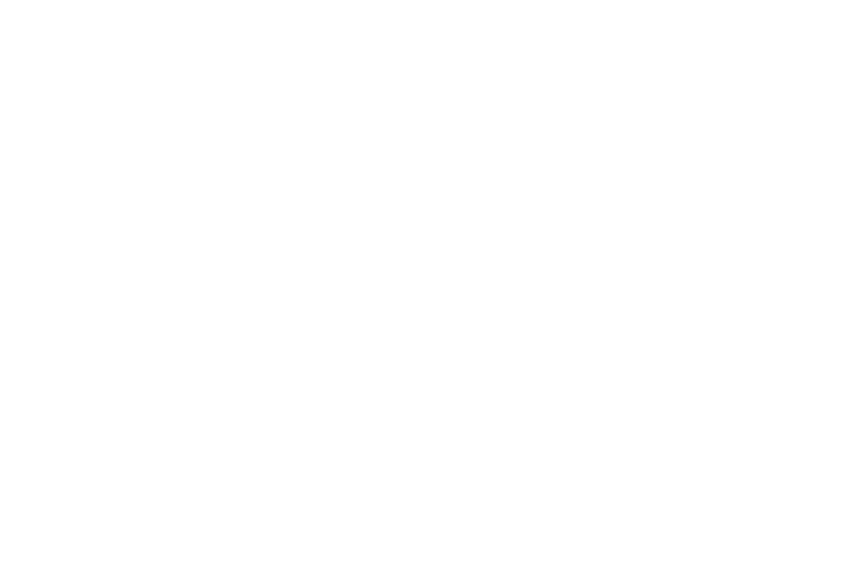

<IPython.core.display.Javascript object>


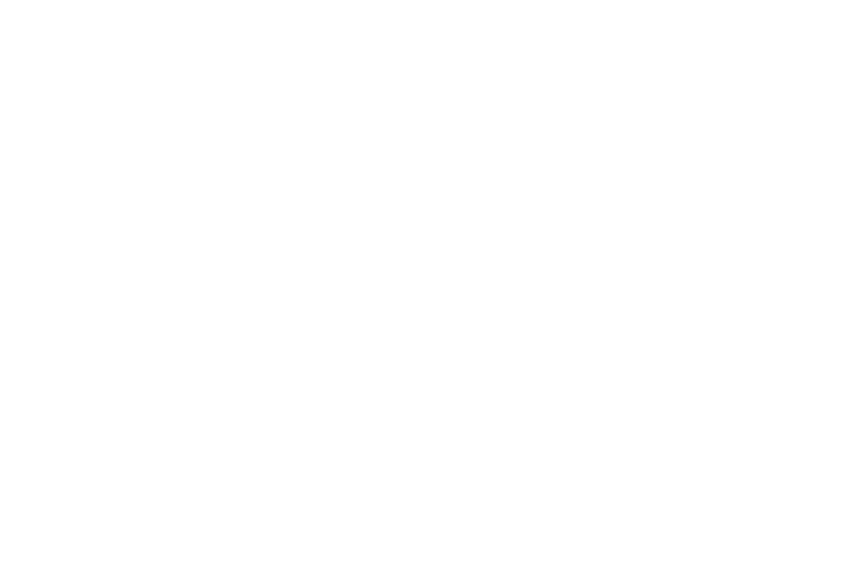

In [185]:
%matplotlib notebook
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False)
plt.show()


In [186]:
print(sklearn.metrics.classification_report(y_test, y_pred,digits=2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         7
           2       0.08      1.00      0.16         7
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         6

    accuracy                           0.08        83
   macro avg       0.01      0.08      0.01        83
weighted avg       0.01      0.08      0.01        83



/Users/nguyenthang/anaconda3/envs/thang/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [150]:
train_score = classifier.score(X_train_std, y_train)
test_score = classifier.score(X_test_std, y_test)

In [151]:
print(train_score,test_score)

0.9068825910931174 0.27710843373493976


In [621]:
yr, sr,mfcc = readAudio2mfcc("data/tournegauche/M11_tournegauche.wav",30)
ipd.Audio(yr,rate=sr)

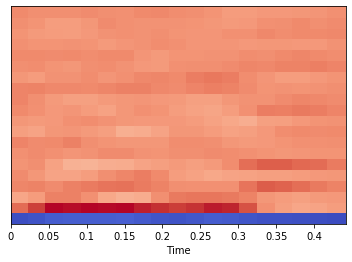

In [630]:
librosa.display.specshow(mfcc, sr=sr, x_axis='time')

In [622]:
labels[9]

'decollage'

In [647]:
yr, sr,mfcc2 = readAudio2mfcc("data/plushaut/NM04_plushaut.wav",20)
ipd.Audio(yr,rate=sr)

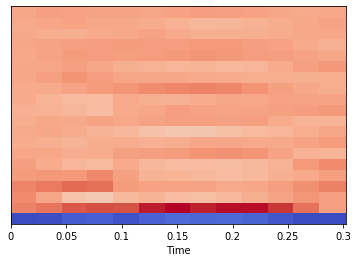

In [631]:
librosa.display.specshow(mfcc2, sr=sr, x_axis='time')

0.5367698877695651


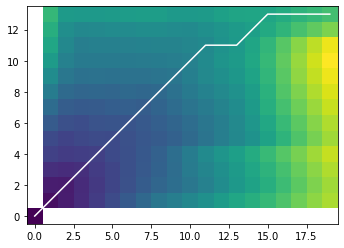

0.5367698877695651

In [632]:
dtw(mfcc.T, mfcc2.T,plot=True)

In [468]:
labels[10]

'avance'

In [469]:
labels[2]

'recule'

In [ ]:
os.listdir